In [79]:
# Data manipulation and numerical operations
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Mutual information and feature selection
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.metrics import mutual_info_score

# Statistical computations (optional for advanced use cases)
from scipy.stats import entropy

# Handling imbalanced data
from imblearn.ensemble import BalancedRandomForestClassifier

# Model explainability
from alibi.explainers.ale import ALE, plot_ale
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

# Permutation Importance
from sklearn.inspection import permutation_importance

# SHAP Values
import shap

# Suppress FutureWarnings
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [80]:
# XAI
import shap
import lime
from anchor import anchor_tabular
from sklearn.inspection import PartialDependenceDisplay

import xgboost

# Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

from sklearn.tree import DecisionTreeRegressor, plot_tree
     

In [84]:
## Read in the Data

folder_path = "./data/"
df_train = pd.read_csv(f"{folder_path}train_selected_features.csv")

X = df_train.drop(columns=['isFraud'])  # Features (all columns except 'isFraud')
y = df_train['isFraud']   

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
model = scaler.fit(X_train)
x_train_scaled = X_train#model.transform(X_train)
x_train_scaled = pd.DataFrame(x_train_scaled, columns=X.columns)
x_test_scaled =X_test# model.transform(X_test)
x_test_scaled = pd.DataFrame(x_test_scaled, columns=X.columns)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


Training data shape: (472432, 15)
Testing data shape: (118108, 15)


In [85]:
# Step 5: Train a Balanced Random Forest model
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(x_train_scaled, y_train)

# Step 6: Evaluate the model
y_pred = brf.predict(x_test_scaled)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, brf.predict_proba(X_test)[:, 1]))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95    113866
           1       0.28      0.84      0.42      4242

    accuracy                           0.92    118108
   macro avg       0.64      0.88      0.69    118108
weighted avg       0.97      0.92      0.94    118108

Confusion Matrix:
 [[104566   9300]
 [   683   3559]]
ROC AUC Score: 0.9448193788718773


In [59]:
'''	
from sklearn import tree
# This may not the best way to view each estimator as it is small
fn=x_test_scaled.columns
cn = [str(cls) for cls in y_test.unique()]  # Convert class names to strings
fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
for index in range(0, 5):
    tree.plot_tree(brf.estimators_[index],
                   feature_names = fn, 
                   class_names=cn,
                   filled = True,
                   ax = axes[index])

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
'''	

"\t\nfrom sklearn import tree\n# This may not the best way to view each estimator as it is small\nfn=x_test_scaled.columns\ncn = [str(cls) for cls in y_test.unique()]  # Convert class names to strings\nfig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)\nfor index in range(0, 5):\n    tree.plot_tree(brf.estimators_[index],\n                   feature_names = fn, \n                   class_names=cn,\n                   filled = True,\n                   ax = axes[index])\n\n    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)\n"

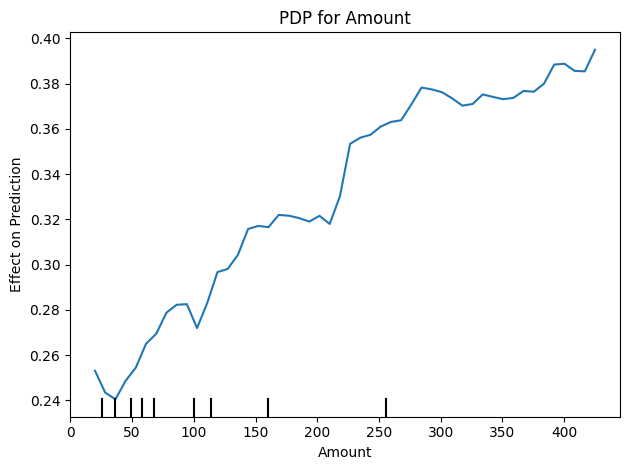

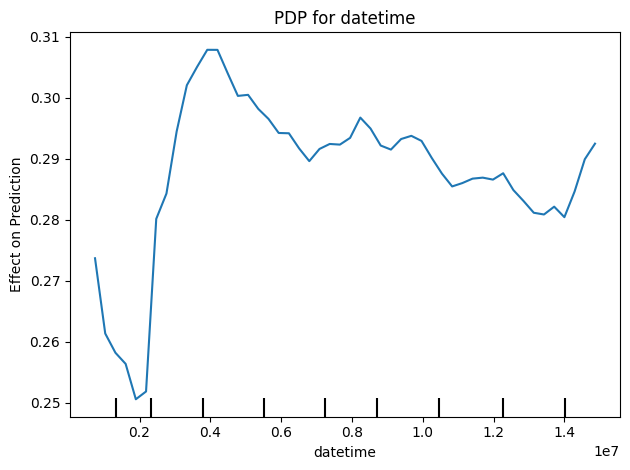

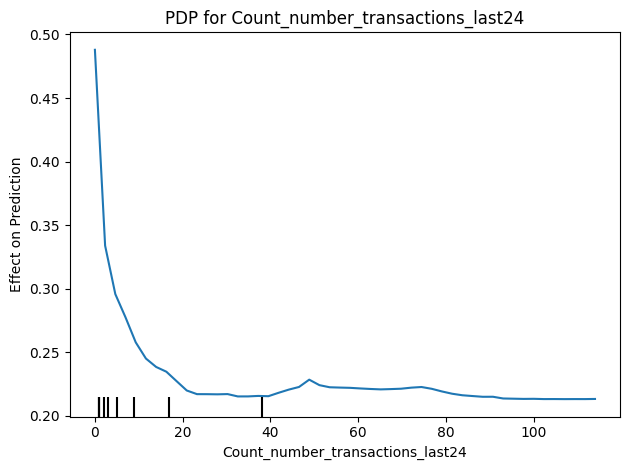

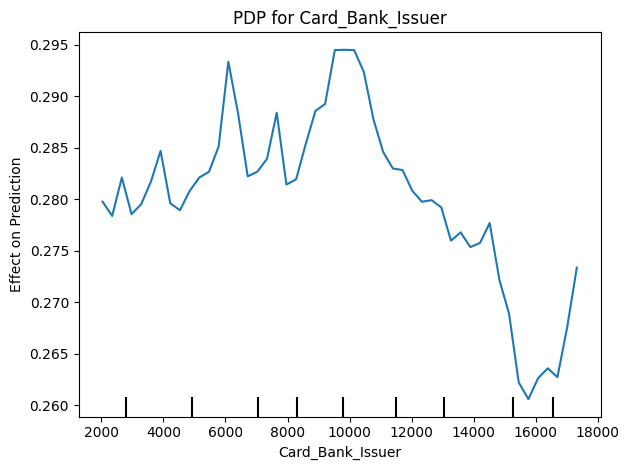

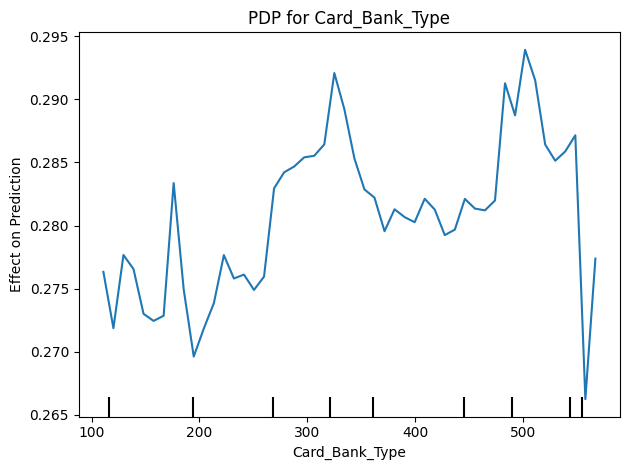

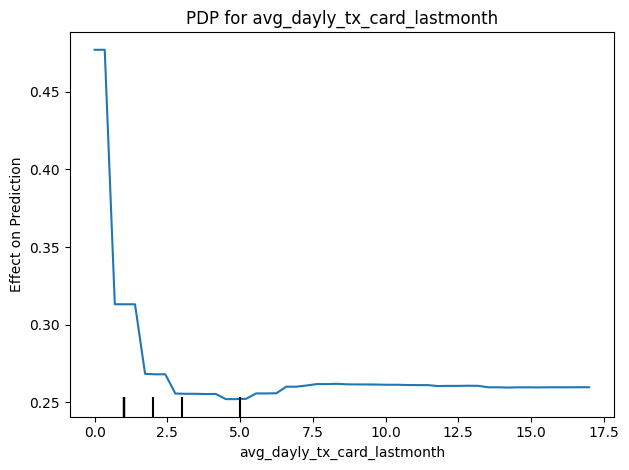

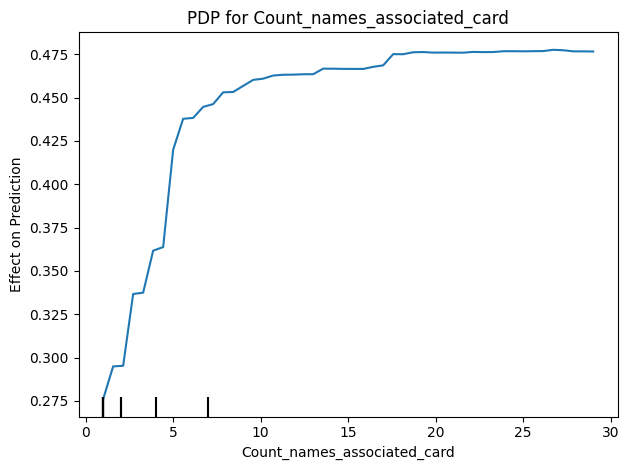

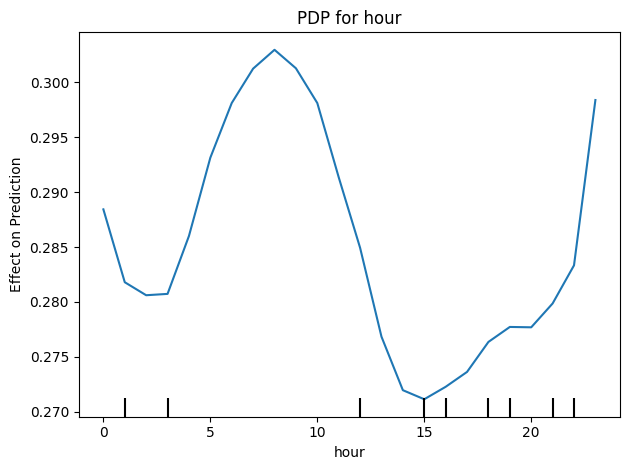

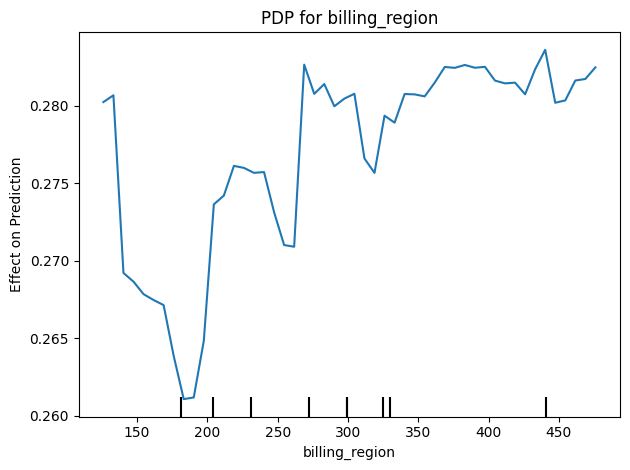

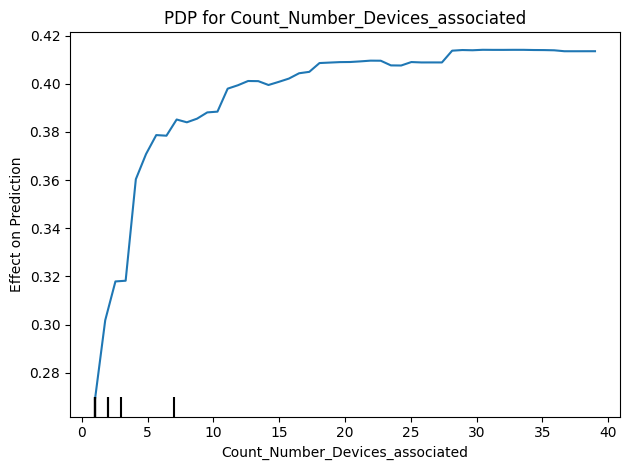

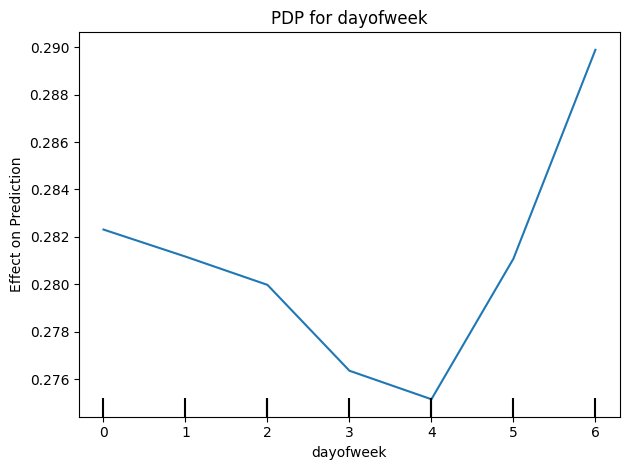

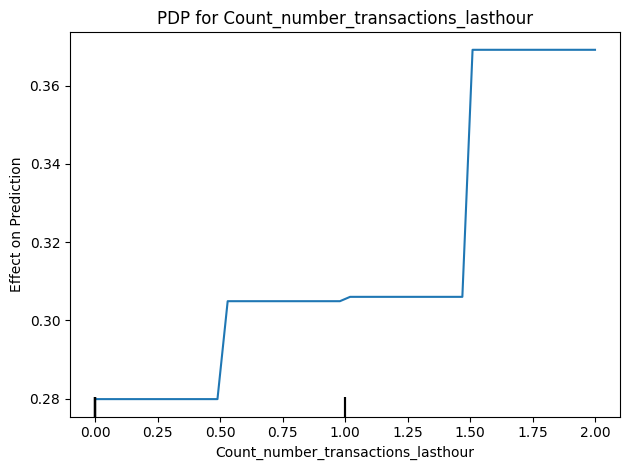

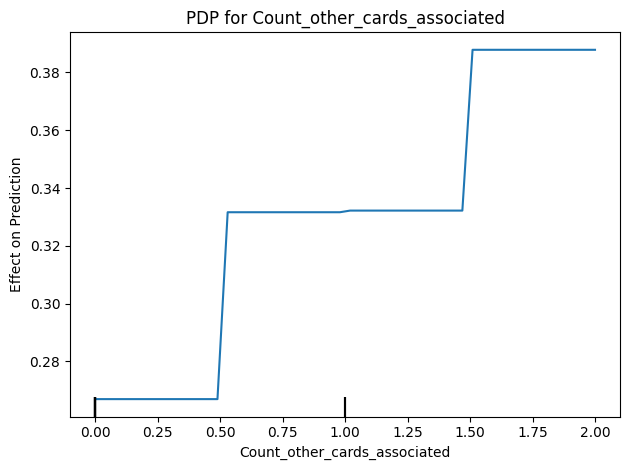

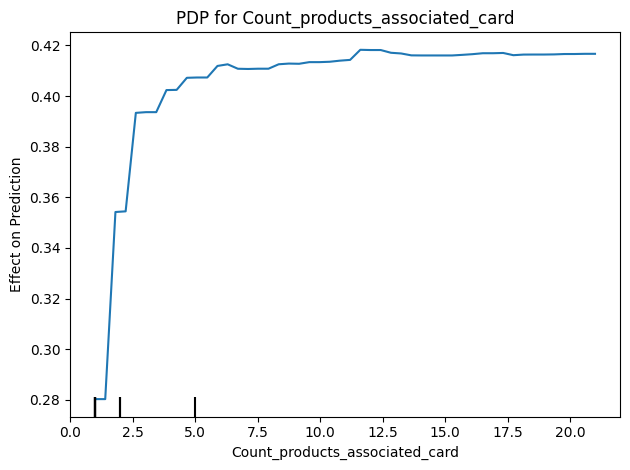

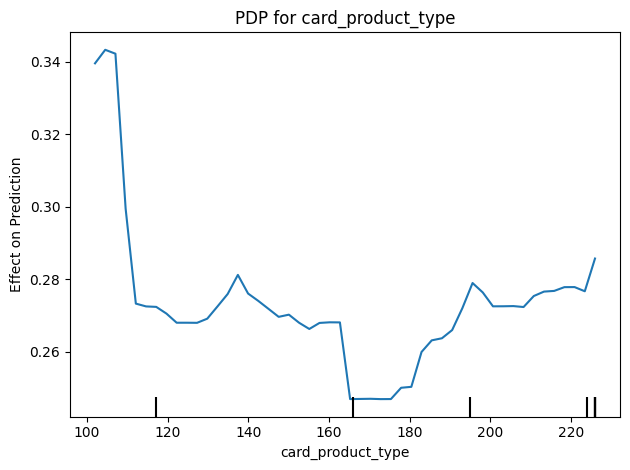

In [86]:
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import matplotlib.pyplot as plt

# Create a copy of the test set and sample a smaller subset
X_test_copy = x_test_scaled.copy()
X_test_sample = X_test_copy.sample(10_000, random_state=42)  # Use the same sampled data

# Plot PDP for the top 15 features
for i, feature in enumerate(X_test_copy.columns):
    feature_idx = list(X_test_copy.columns).index(feature)  # Get the feature index
    PartialDependenceDisplay.from_estimator(
        brf,  # Random Forest model
        X_test_sample,  # Sampled data
        [feature_idx],  # Single feature
        grid_resolution=50,  # Number of evaluation points
    )
    plt.title(f"PDP for {feature}")
    plt.xlabel(feature)
    plt.ylabel("Effect on Prediction")
    plt.tight_layout()
    plt.show()

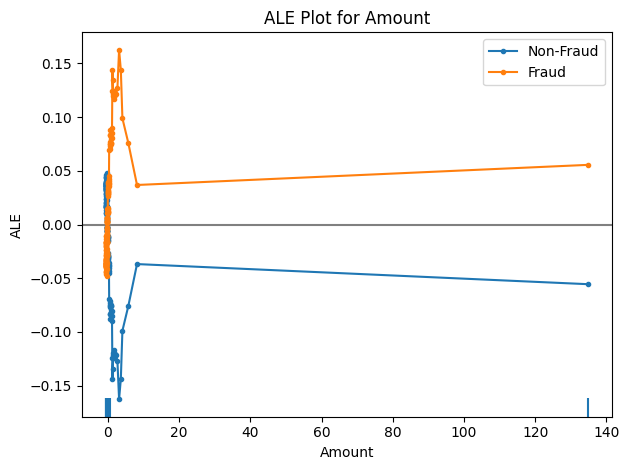

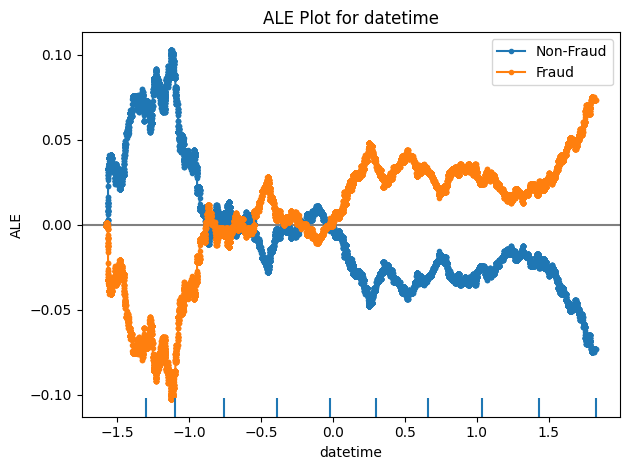

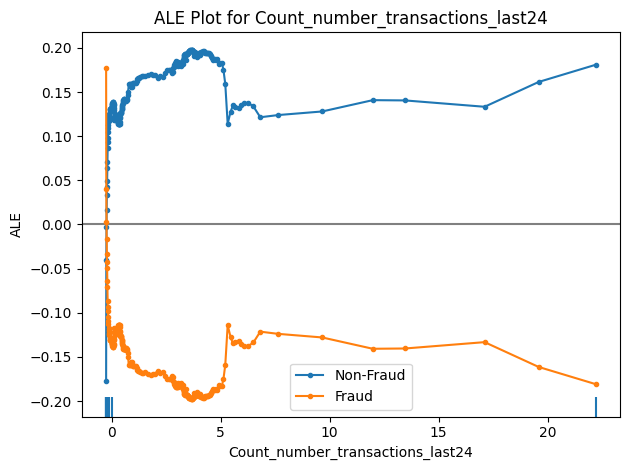

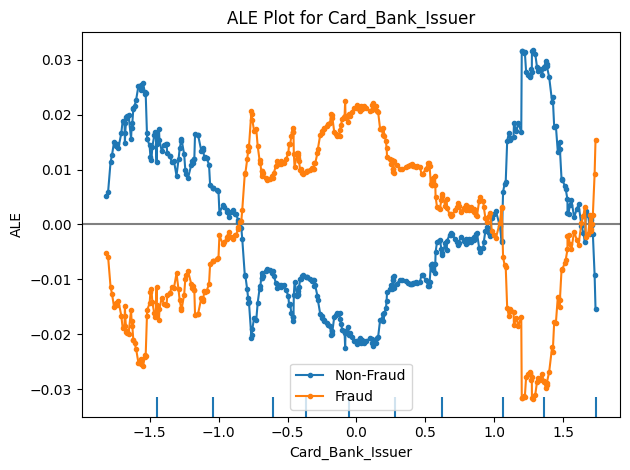

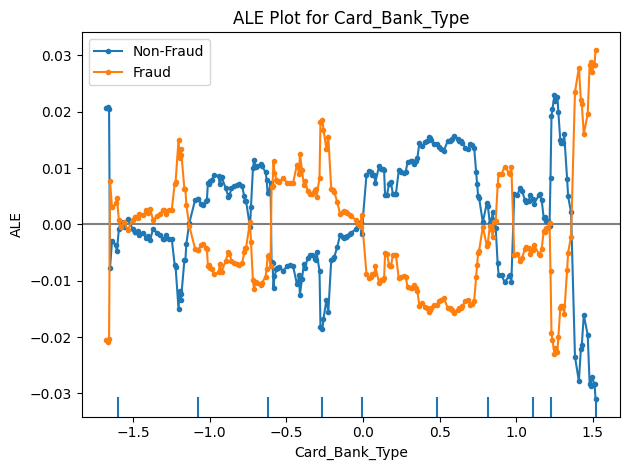

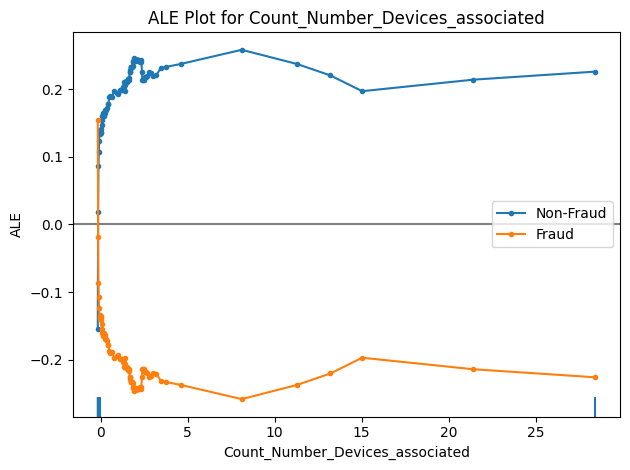

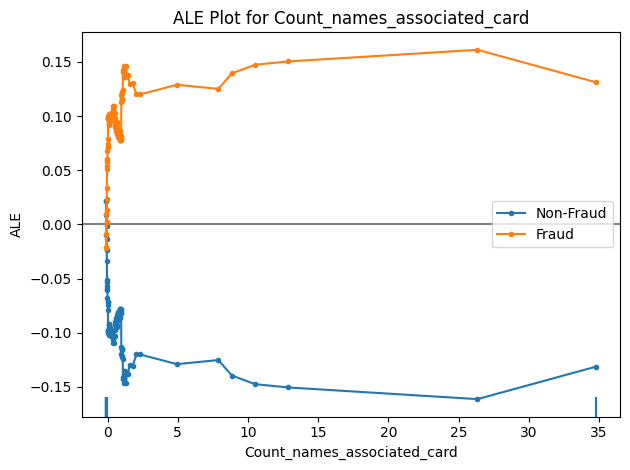

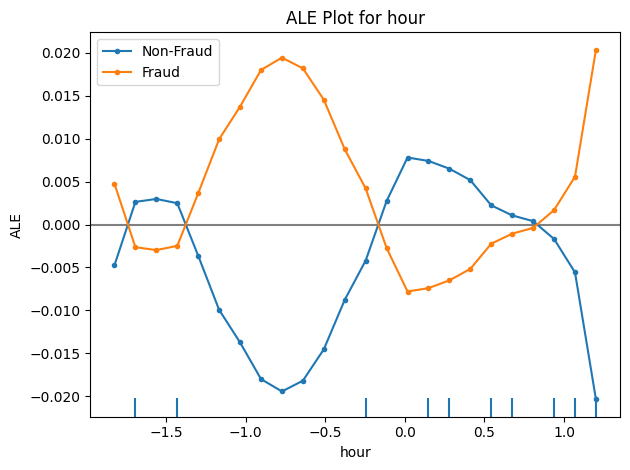

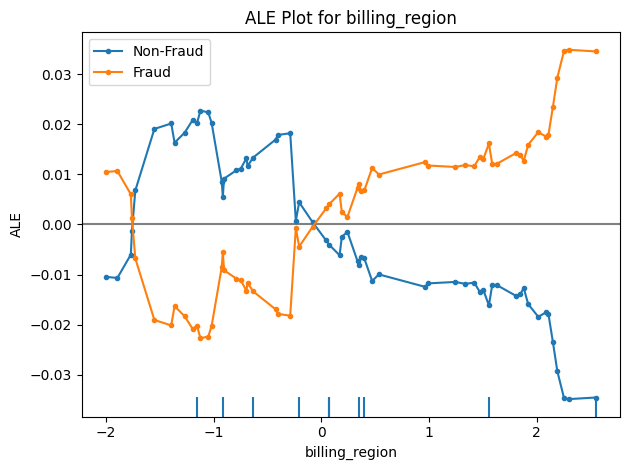

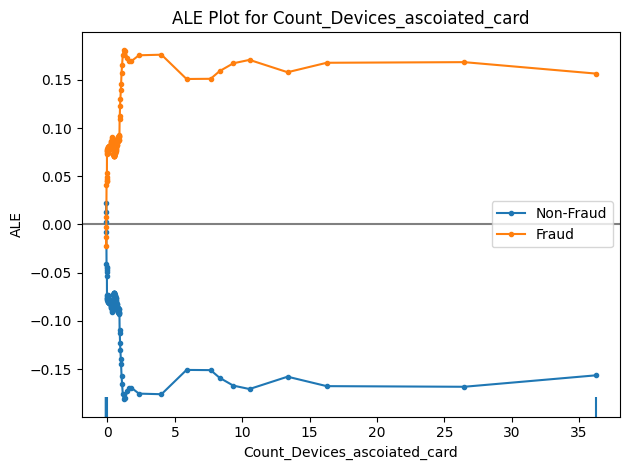

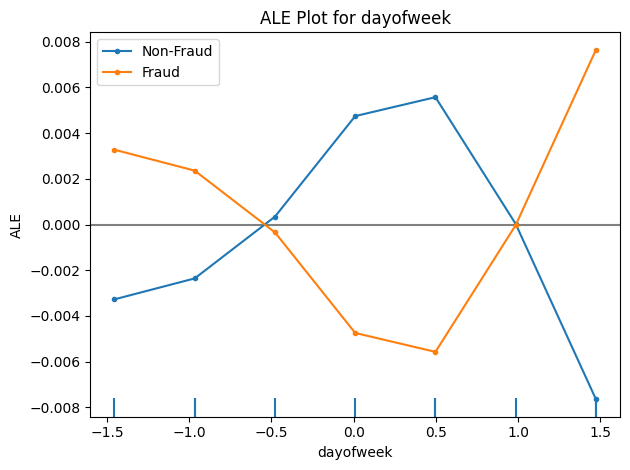

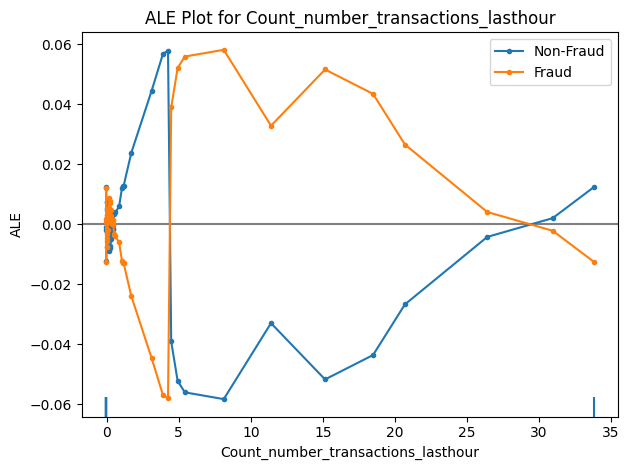

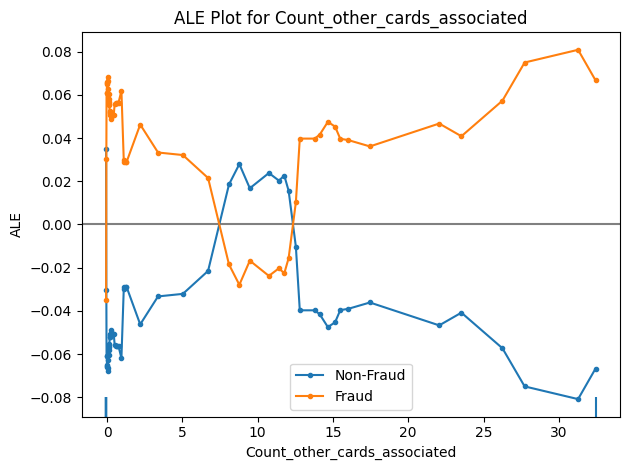

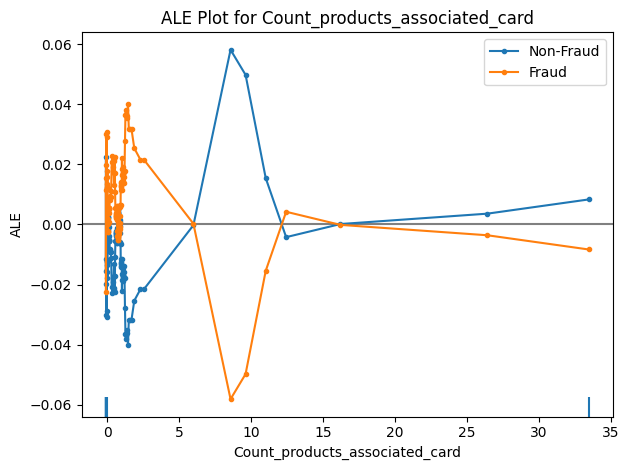

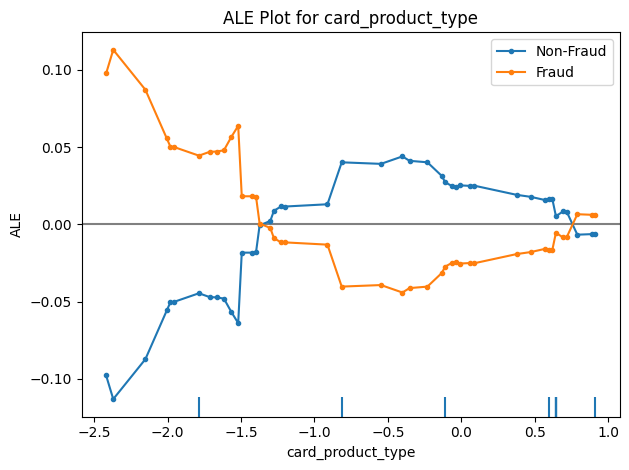

In [65]:
from alibi.explainers import ALE
from alibi.explainers.ale import plot_ale
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd


# Step 4: Use a wrapper function for predictions to include valid feature names
def wrapped_predict_proba(X):
    """
    Ensure predictions are made with valid feature names.
    """
    if isinstance(X, np.ndarray):  # If input is a NumPy array
        X = pd.DataFrame(X, columns=x_test_scaled.columns)  # Convert back to DataFrame
    return brf.predict_proba(X)


# Initialize ALE Explainer
ale_explainer = ALE(
    predictor=wrapped_predict_proba,  # Wrapped function ensures feature names are used
    feature_names=x_test_scaled.columns.tolist(),  # Feature names for ALE plots
    target_names=["Non-Fraud", "Fraud"],
)

# Step 5: Compute ALE on the sampled data
ale_result = ale_explainer.explain(
    x_test_scaled.to_numpy()
)  # Use NumPy array for ALE computation

# Step 6: Plot ALE for each top feature
for feature_idx, feature_name in enumerate(x_test_scaled.columns):
    try:
        plot_ale(ale_result, features=[feature_idx])
        plt.title(f"ALE Plot for {feature_name}")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error generating ALE plot for feature '{feature_name}': {e}")

In [9]:
X100 = shap.utils.sample(x_test_scaled, 10)

sample_ind = 20

explainer = shap.TreeExplainer(brf, X100)
shap_values = explainer(X)

100%|===================| 1181024/1181080 [206:30<00:00]        

In [ ]:
import pickle
import shap

# Assuming you have your shap_values calculated
with open('shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

In [21]:
explain = shap.Explanation(shap_values.values, shap_values.base_values[0][0], shap_values.data)

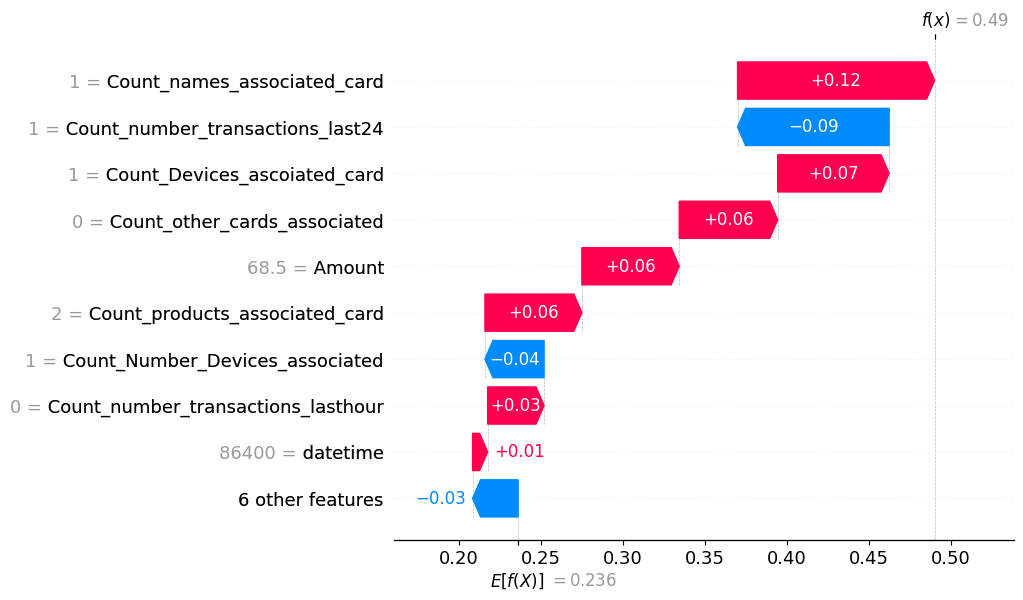

In [24]:
id_to_explain = 0
output_to_explain = 1
shap.plots.waterfall(shap_values[id_to_explain,:,output_to_explain])

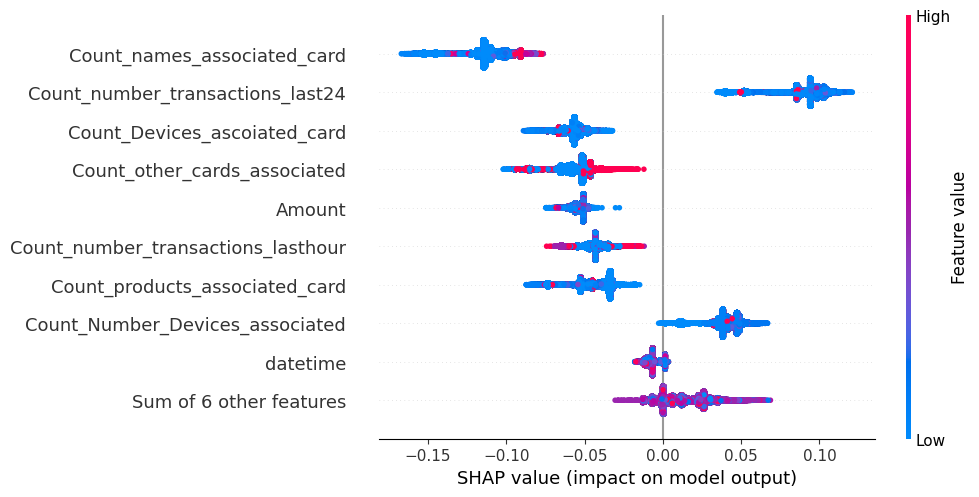

In [29]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values[:,:,id_to_explain])

In [73]:
# Extract SHAP values for "Fraud" (class index 1)
shap_values_fraud = shap_values[:X_test.shape[0], :, 1]  # Select first 118108 samples, Fraud class
# Check the new shape
print(f"shap_values_fraud shape: {shap_values_fraud.shape}")
# Verify feature names and data shapes
print(f"X_test shape: {X_test.shape}")
print(f"shap_values shape: {shap_values.shape}")

shap_values_fraud shape: (118108, 15)
X_test shape: (118108, 15)
shap_values shape: (590540, 15, 2)


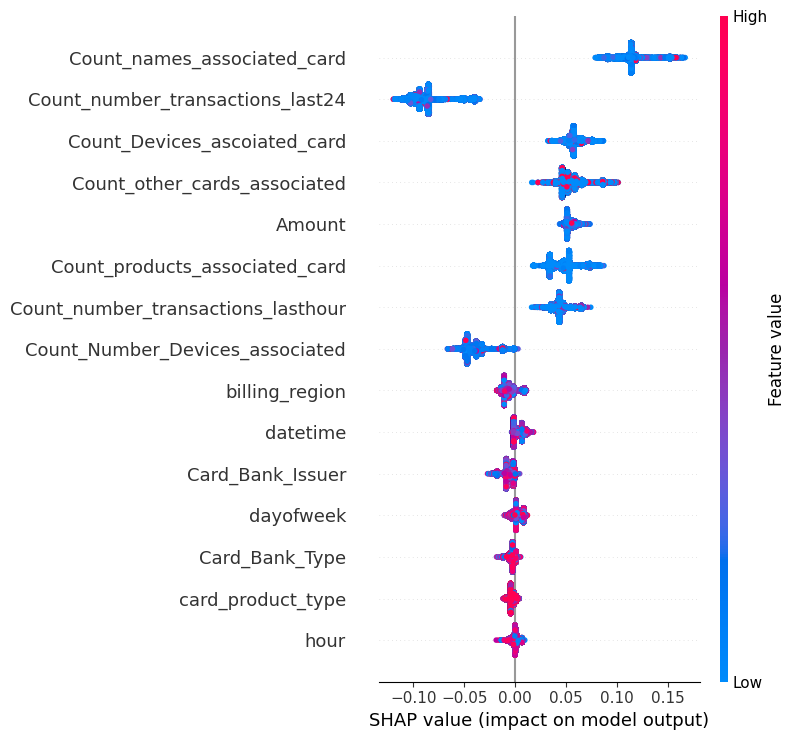

In [74]:
shap.summary_plot(shap_values_fraud, X_test, feature_names=X_test.columns)

In [ ]:
# Choose a sample for explanation
idx = 100

# Plot waterfall plot
shap.plots.waterfall(shap_values[idx])